# Naive representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 5.14690112e-03+1.05036153e-02j -1.01243230e-02+1.14227347e-02j
  -5.89228282e-03-5.88601269e-03j  1.71917665e-03+4.72567836e-03j
  -8.75546783e-03+1.03323972e-02j -1.15890019e-02-2.41379510e-03j
  -4.89886058e-03-9.27943923e-03j  1.12785015e-03-1.72572322e-02j
  -5.09621241e-05-1.91251002e-02j  9.56362765e-03+1.52911656e-02j]
 [ 9.10926514e+01+3.93541832e+01j  2.70720944e-03+3.04538454e-03j
  -1.56138856e-02+2.20983499e-03j -9.42870695e-03+8.78419634e-03j
  -3.68940178e-03+1.00500882e-02j -2.95070768e-03-6.12311671e-03j
   1.04144681e-02+8.08280893e-03j -1.27931954e-02-3.27803078e-03j
   8.43335316e-03-1.73714373e-03j -9.50016920e-03+1.97011488e-03j]
 [ 8.21080627e+01+5.05564728e+01j -1.38683906e-02-2.08460521e-02j
   2.67090509e-03+8.86797346e-03j  8.80727835e-04-5.42564504e-03j
   6.76319702e-03+8.18572007e-03j -2.45797518e-03-2.11730562e-02j
   4.97089652e-03+2.37061596e-03j  5.92742115e-03-4.85933432e-03j
   9.61425900e-03+4.56003072e-05j  1.56238545e-02+1.28463628e-02j]
 [ 3.11

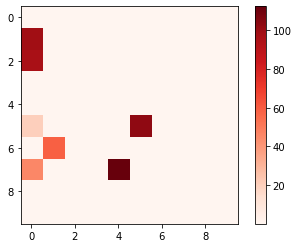

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 375.08282  +340.89624j   209.68008   -72.268166j
   234.45415  +308.78363j   282.70718   -74.24744j
    91.67337  +190.3144j    216.86311   +91.55765j
   143.87894  +149.31676j   103.07198  +196.13672j
   318.91772  +242.45618j    98.37216   +94.58786j ]
 [ -60.805294 -116.35334j   213.48294   +56.659325j
    -4.959216 -200.80437j   200.94446  +169.2274j
   183.18637  -270.7263j    106.23891   +60.602856j
   243.4587   -229.39241j    60.3297   -119.296394j
    92.777214 -133.74402j   126.45804  -121.719315j]
 [  76.07039  -243.38986j   -15.361105 -244.53015j
   131.1457   -206.4542j   -150.15144  -320.62457j
    96.80367   -11.338826j  -55.26124  -356.5785j
    20.760414  +72.30361j   137.8213   -302.21722j
     7.8952785 -71.31216j   162.53754  -233.24115j ]
 [  26.425243 -129.11543j   -87.9741    -10.393051j
     5.7228217 -58.806038j   68.66929  -109.76475j
  -131.83528  -172.61588j    91.464325  -47.528015j
  -195.94778  -313.2601j    -50.926384  +90.36022j
   -98.30431  -286.29

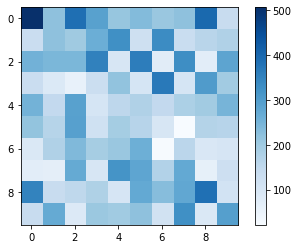

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [7]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.4355159e-13
Imaginaries MSE: 1.2033583e-13


In [8]:
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [9]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [10]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

In [11]:
# measurement
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Test 2')

#qc.measure_all()
#backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
#job = backend.run(qc, shots=1, memory=True) 
#output = job.result().get_memory()[0]
#out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002016B6B9040>"'

In [ ]:
fidelity = np.fft.ifft2(readout).astype('complex64')

In [ ]:
test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(fidelity)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)